## Uber Express Pool Case Study

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

### 1. Load Data

In [2]:
# Load data
dt = pd.read_excel('619702-XLS-ENG.xlsx', sheet_name = 'Switchbacks')
dt.head()

,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches
0,Boston,2018-02-19 07:00:00,2,False,True,1415,3245,256,34458.411634,3372,1476
1,Boston,2018-02-19 09:40:00,5,True,False,1461,2363,203,29764.349821,2288,1275
2,Boston,2018-02-19 12:20:00,2,False,False,1362,2184,118,27437.367363,2283,962
3,Boston,2018-02-19 15:00:00,5,True,True,1984,3584,355,44995.452993,4035,2021
4,Boston,2018-02-19 17:40:00,2,False,False,1371,2580,181,27583.955295,2200,979


In [3]:
# Clean and Create Useful Variables
dt['tot_trips'] = dt['trips_pool'] + dt['trips_express']
dt['cost_per_trip'] = dt['total_driver_payout'] / dt['tot_trips']
dt['single_matches'] = dt['total_matches'] - dt['total_double_matches']
dt['unmatched_trips'] = dt['tot_trips'] - dt['total_matches']

dt[['unmatched_trips', 'single_matches', 'total_double_matches', 'tot_trips']].describe()

dt['match_rate'] = dt['total_matches'] / dt['tot_trips']
dt['double_match_rate'] = dt['total_double_matches'] / dt['tot_trips']
dt['single_match_rate'] = dt['single_matches'] / dt['tot_trips']
dt['no_match_rate'] = dt['unmatched_trips'] / dt['tot_trips']

In [4]:
dt.columns

Index(['city_id', 'period_start', 'wait_time', 'treat', 'commute',
       'trips_pool', 'trips_express', 'rider_cancellations',
       'total_driver_payout', 'total_matches', 'total_double_matches',
       'tot_trips', 'cost_per_trip', 'single_matches', 'unmatched_trips',
       'match_rate', 'double_match_rate', 'single_match_rate',
       'no_match_rate'],
      dtype='object')

### 2. Data Distribution

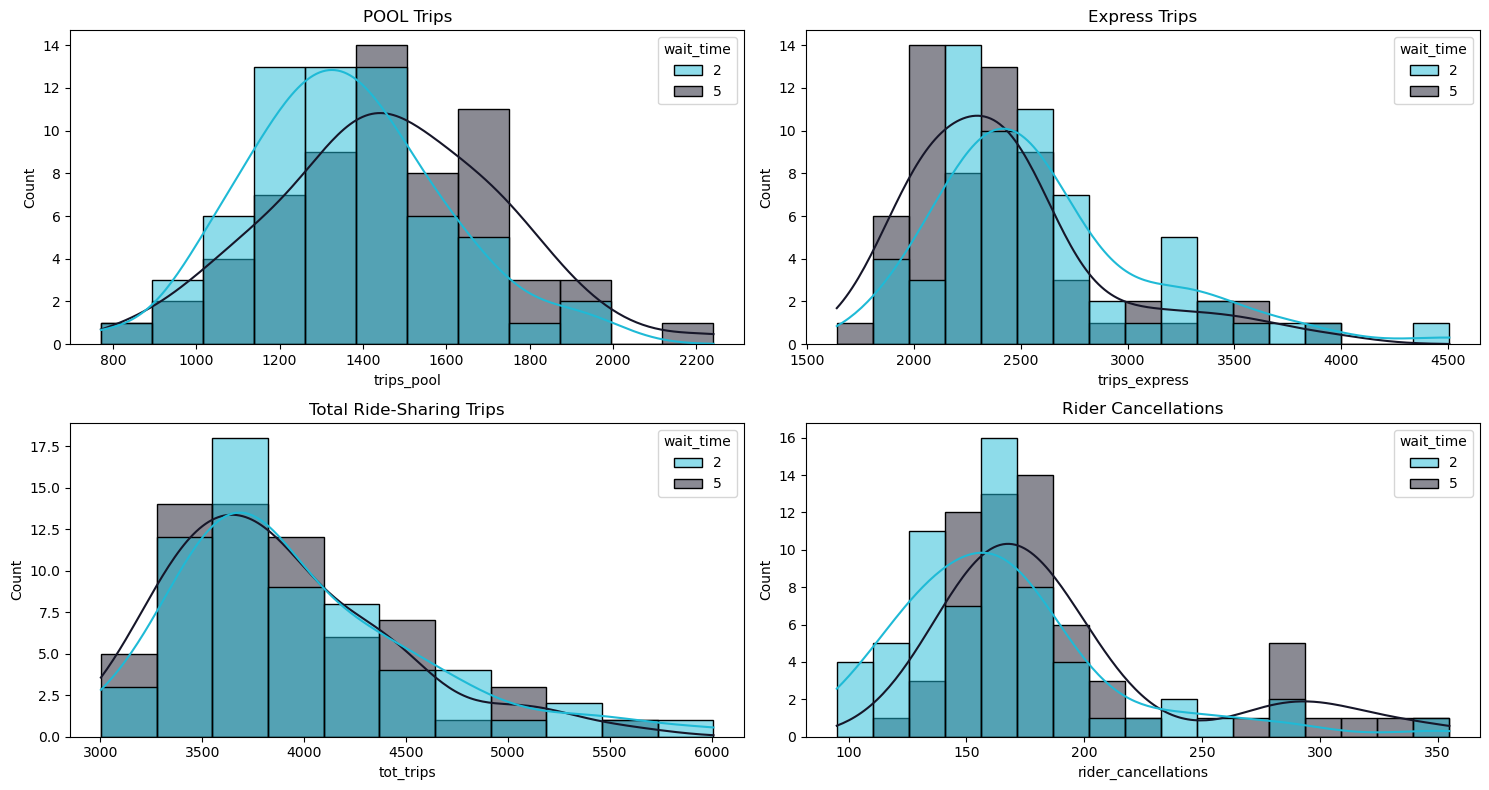

In [5]:
# Density plots - customer experience metrics
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.histplot(data=dt, x='trips_pool', hue='wait_time', alpha=0.5, kde=True, palette=['#1fbad6', '#161629'])
plt.title('POOL Trips')

plt.subplot(2, 2, 2)
sns.histplot(data=dt, x='trips_express', hue='wait_time', alpha=0.5, kde=True, palette=['#1fbad6', '#161629'])
plt.title('Express Trips')

plt.subplot(2, 2, 3)
sns.histplot(data=dt, x='tot_trips', hue='wait_time', alpha=0.5, kde=True, palette=['#1fbad6', '#161629'])
plt.title('Total Ride-Sharing Trips')

plt.subplot(2, 2, 4)
sns.histplot(data=dt, x='rider_cancellations', hue='wait_time', alpha=0.5, kde=True, palette=['#1fbad6', '#161629'])
plt.title('Rider Cancellations')

plt.tight_layout()
plt.savefig('spread.png')
plt.show()

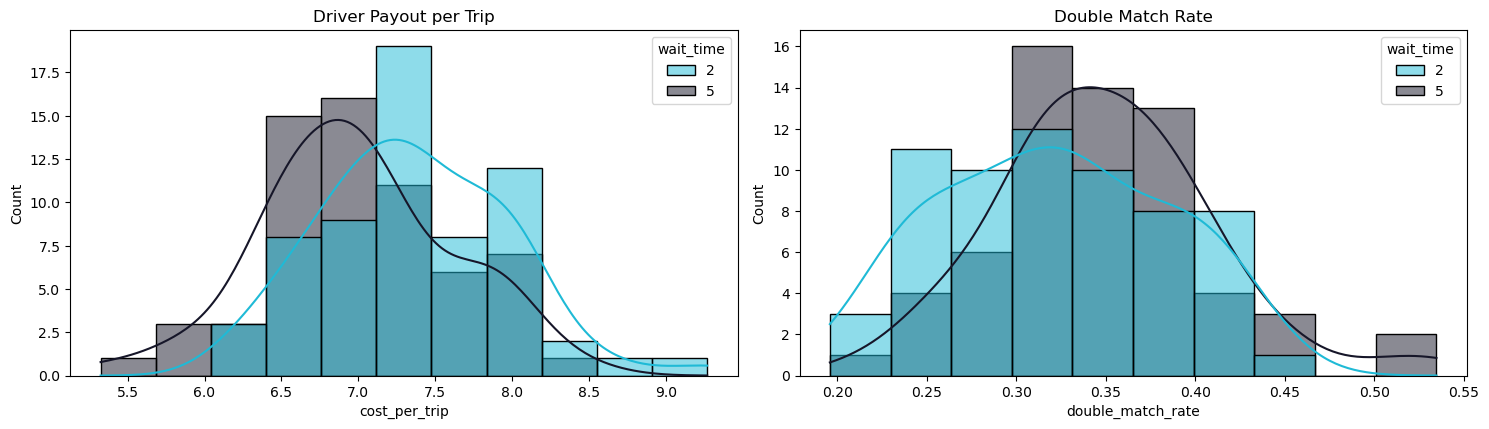

In [6]:
# Density plots - efficiency metrics
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.histplot(data=dt, x='cost_per_trip', hue='wait_time', alpha=0.5, kde=True, palette=['#1fbad6', '#161629'])
plt.title('Driver Payout per Trip')

plt.subplot(2, 2, 2)
sns.histplot(data=dt, x='double_match_rate', hue='wait_time', alpha=0.5, kde=True, palette=['#1fbad6', '#161629'])
plt.title('Double Match Rate')

plt.tight_layout()
plt.savefig('spread2.png')
plt.show()

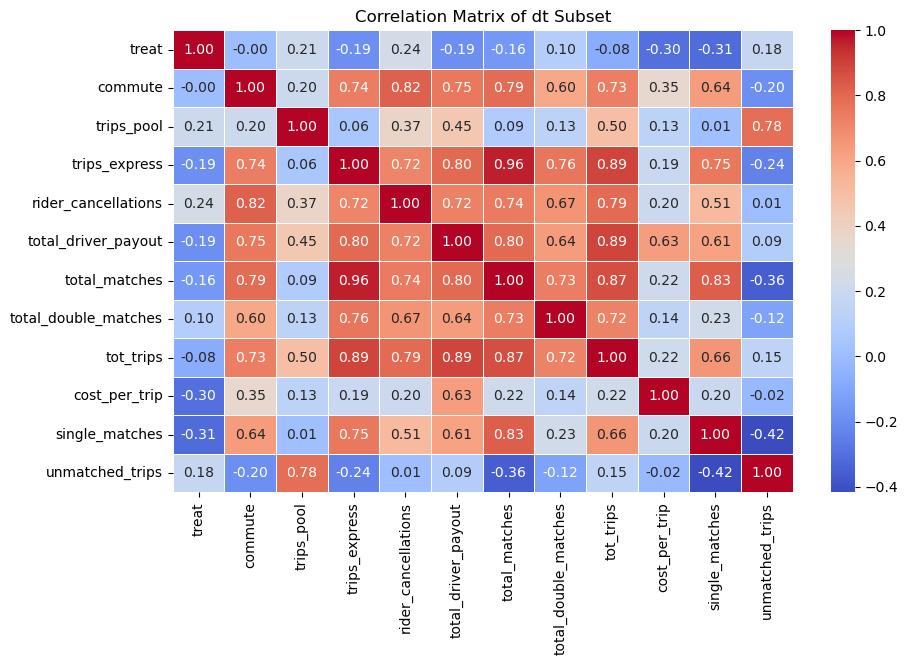

In [7]:
# Drop specified columns
corr_data = dt.drop(['city_id', 'period_start', 'wait_time', 'match_rate', 'double_match_rate', 'single_match_rate',
       'no_match_rate'], axis=1)

# Calculating the correlation matrix
correlation_matrix = corr_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of dt Subset')

plt.savefig('corr-matrix.png')
plt.show()



### 3. Test Assumptions

In [8]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Define the dependent variables
dependent_vars = ['rider_cancellations', 'trips_pool', 'cost_per_trip', 'total_matches', 'double_match_rate']

# Perform MANOVA
manova = MANOVA.from_formula(' + '.join(dependent_vars) + ' ~ treat', data=dt)
results = manova.mv_test()

# Print results
print(results)

                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
       Intercept         Value   Num DF  Den DF   F Value  Pr > F
-----------------------------------------------------------------
          Wilks' lambda   0.0092 5.0000 120.0000 2572.0318 0.0000
         Pillai's trace   0.9908 5.0000 120.0000 2572.0318 0.0000
 Hotelling-Lawley trace 107.1680 5.0000 120.0000 2572.0318 0.0000
    Roy's greatest root 107.1680 5.0000 120.0000 2572.0318 0.0000
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
             treat          Value  Num DF  Den DF  F Value Pr > F
-----------------------------------------------------------------
              Wilks' lambda 0.5465 5.0000 120.0000 19.9141 0.0000
             Pillai's trace 0.

In [9]:
#t-test for each variable
ttest_pool = ttest_ind(dt[dt['treat'] == False]['trips_pool'], dt[dt['treat'] == True]['trips_pool'])
ttest_express = ttest_ind(dt[dt['treat'] == False]['trips_express'], dt[dt['treat'] == True]['trips_express'])
ttest_cancellations = ttest_ind(dt[dt['treat'] == False]['rider_cancellations'], dt[dt['treat'] == True]['rider_cancellations'])
ttest_cost_per_trip = ttest_ind(dt[dt['treat'] == False]['cost_per_trip'], dt[dt['treat'] == True]['cost_per_trip'])
ttest_match_rate = ttest_ind(dt[dt['treat'] == False]['match_rate'], dt[dt['treat'] == True]['match_rate'])

# Printing out the results
print("T-test results:")
print("trips_pool:", ttest_pool)
print("trips_express:", ttest_express)
print("rider_cancellations:", ttest_cancellations)
print("cost_per_trip:", ttest_cost_per_trip)
print("match_rate:", ttest_match_rate)

T-test results:
trips_pool: TtestResult(statistic=-2.3334843926729363, pvalue=0.021232396600015767, df=124.0)
trips_express: TtestResult(statistic=2.2015160137355108, pvalue=0.02955001543931055, df=124.0)
rider_cancellations: TtestResult(statistic=-2.7640050528783227, pvalue=0.0065808982457568384, df=124.0)
cost_per_trip: TtestResult(statistic=3.4621410571047204, pvalue=0.0007359364864662961, df=124.0)
match_rate: TtestResult(statistic=2.516928763195693, pvalue=0.013114044629773199, df=124.0)


**Results:**

The MANOVA analysis is comparing the differences in the dependent variables between below two groups:

Group 1: 'TRUE' - This group represents observations where the treatment condition is met, i.e., the wait time is 5 minutes.

Group 2: 'FALSE' - This group represents observations where the treatment condition is not met, i.e., the wait time is 2 minutes.

Multivariate linear model (MANOVA):
 - The MANOVA test indicates that there are statistically significant differences between the groups defined by the 'treat' variable (wait time) across all the dependent variables **collectively** and **individually**.

From the t-tests:
 - The low p-values, suggest that there is a statistically significant difference in the number of **POOL trips**, **Express trips**, **rider cancellations**, **cost per trip** and **match rate** between the two groups.

In [10]:
import pandas as pd
from scipy.stats import chi2_contingency

# Function to perform chi-square test and print results
def chi_square_test(data, condition):
    # Subset the data based on the condition
    subset_data = data[(data['commute'] == condition[0]) & (data['treat'] == condition[1])]
    
    # Count the number of Pool rides and Express rides in the subset
    pool_count = subset_data[subset_data['trips_pool'] > 0].shape[0]
    express_count = subset_data[subset_data['trips_express'] > 0].shape[0]

    # Create a contingency table
    contingency_table = [[pool_count, express_count]]

    # Perform chi-square test of independence
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    # Print the results
    print("For condition: Treat =", condition[1], "and Commute =", condition[0])
    print("Chi-square statistic:", chi2)
    print("P-value:", p_value)

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: There is evidence to suggest that the count of Pool rides is greater than the count of Express rides.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference in the counts of Pool rides and Express rides.")
    print()

# Define conditions for different combinations of commute and treat values
conditions = [
    (False, False),
    (False, True),
    (True, False),
    (True, True)
]

# Perform chi-square test for each condition
for condition in conditions:
    chi_square_test(dt, condition)


For condition: Treat = False and Commute = False
Chi-square statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference in the counts of Pool rides and Express rides.

For condition: Treat = True and Commute = False
Chi-square statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference in the counts of Pool rides and Express rides.

For condition: Treat = False and Commute = True
Chi-square statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference in the counts of Pool rides and Express rides.

For condition: Treat = True and Commute = True
Chi-square statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference in the counts of Pool rides and Express rides.



In [11]:
# Compute the total number of ride-sharing trips
dt['tot_trips'] = dt['trips_pool'] + dt['trips_express']

# Subset the data for the control and treatment groups
control_group = dt.loc[dt['treat'] == False, 'tot_trips']
treatment_group = dt.loc[dt['treat'] == True, 'tot_trips']

# Perform the hypothesis test
t_statistic, p_value = ttest_ind(control_group, treatment_group)

# Print the results
print("T-test statistic:", t_statistic)
print("P-value:", p_value)

T-test statistic: 0.8493551196605631
P-value: 0.3973205481597256


> With a p-value greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is **not enough evidence** to conclude that extending wait times changes the total number of ride-sharing trips.

### 4. OLS Regressions

In [12]:
model_pool = ols('trips_pool ~ treat', data=dt).fit()
model_express = ols('trips_express ~ treat', data=dt).fit()
model_cancellations = ols('rider_cancellations ~ treat', data=dt).fit()
model_cost_per_trip = ols('cost_per_trip ~ treat', data=dt).fit()
model_match_rate = ols('match_rate ~ treat', data=dt).fit()

In [13]:
from statsmodels.iolib.summary2 import summary_col

#models to be included in the summary
models = [model_pool, model_express, model_cancellations, model_cost_per_trip, model_match_rate]

#dependent variable names for each model
dependent_vars = ['trips_pool', 'trips_express', 'rider_cancellations', 'cost_per_trip', 'match_rate']

#summary table formatting
summary = summary_col(models, stars=True, float_format='%0.3f', model_names=dependent_vars)

print(summary)


                trips_pool trips_express rider_cancellations cost_per_trip match_rate
-------------------------------------------------------------------------------------
Intercept      1355.317*** 2611.667***   165.349***          7.365***      0.659***  
               (31.933)    (61.760)      (6.339)             (0.077)       (0.010)   
treat[T.True]  105.381**   -192.286**    24.778***           -0.377***     -0.035**  
               (45.160)    (87.342)      (8.964)             (0.109)       (0.014)   
R-squared      0.042       0.038         0.058               0.088         0.049     
R-squared Adj. 0.034       0.030         0.050               0.081         0.041     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Result:

 - The coefficient for treat[T.True] indicates the change in the dependent variable when the treatment variable changes from False to True.Thus we expect number of Cancellations to increase and the Cost per Trip to decrease as we incraese the wait time from 2 to 5 mins.  

In [14]:
model_pool = ols('trips_pool ~ treat+ commute', data=dt).fit()
model_express = ols('trips_express ~ treat+ commute', data=dt).fit()
model_cancellations = ols('rider_cancellations ~ treat+ commute', data=dt).fit()
model_cost_per_trip = ols('cost_per_trip ~ treat+ commute', data=dt).fit()
model_match_rate = ols('match_rate ~ treat+ commute', data=dt).fit()

In [15]:
from statsmodels.iolib.summary2 import summary_col

#models to be included in the summary
models = [model_pool, model_express, model_cancellations, model_cost_per_trip, model_match_rate]

#dependent variable names for each model
dependent_vars = ['trips_pool', 'trips_express', 'rider_cancellations', 'cost_per_trip', 'match_rate']

#summary table formatting
summary = summary_col(models, stars=True, float_format='%0.3f', model_names=dependent_vars)

print(summary)


                 trips_pool trips_express rider_cancellations cost_per_trip match_rate
--------------------------------------------------------------------------------------
Intercept       1332.451*** 2453.115***   146.988***          7.268***      0.640***  
                (32.798)    (42.864)      (3.541)             (0.075)       (0.009)   
treat[T.True]   105.381**   -192.286***   24.778***           -0.377***     -0.035*** 
                (44.339)    (57.947)      (4.786)             (0.102)       (0.012)   
commute[T.True] 144.058**   998.878***    115.673***          0.612***      0.118***  
                (60.667)    (79.287)      (6.549)             (0.139)       (0.016)   
R-squared       0.084       0.580         0.734               0.212         0.348     
R-squared Adj.  0.069       0.573         0.729               0.199         0.337     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
